In [14]:
import numpy as np
from numpy import linalg as LA
from numpy.random import multivariate_normal
from scipy.stats import wishart

def Normal_Wishart(mu_0, lamb, W, nu, seed=None):
    """Function drawing a Gaussian-Wishart random variable"""
    Lambda = wishart(df=nu, scale=W, seed=seed).rvs()
    cov = np.linalg.inv(lamb * Lambda)
    mu = multivariate_normal(mu_0, cov)
    return mu, Lambda

# Matrix Computation Concepts

## Kronecker product

- **Definition**:

Given two matrices $A\in\mathbb{R}^{m_1\times n_1}$ and $B\in\mathbb{R}^{m_2\times n_2}$, then, the **Kronecker product** between these two matrices is defined as

$$A\otimes B=\left[ \begin{array}{cccc} a_{11}B & a_{12}B & \cdots & a_{1m_2}B \\ a_{21}B & a_{22}B & \cdots & a_{2m_2}B \\ \vdots & \vdots & \ddots & \vdots \\ a_{m_11}B & a_{m_12}B & \cdots & a_{m_1m_2}B \\ \end{array} \right]$$
where the symbol $\otimes$ denotes Kronecker product, and the size of resulted $A\otimes B$ is $(m_1m_2)\times (n_1n_2)$ (i.e., $m_1\times m_2$ columns and $n_1\times n_2$ rows).

- **Example**:

If $A=\left[ \begin{array}{cc} 1 & 2 \\ 3 & 4 \\ \end{array} \right]$ and $B=\left[ \begin{array}{ccc} 5 & 6 & 7\\ 8 & 9 & 10 \\ \end{array} \right]$, then, we have

$$A\otimes B=\left[ \begin{array}{cc} 1\times \left[ \begin{array}{ccc} 5 & 6 & 7\\ 8 & 9 & 10\\ \end{array} \right] & 2\times \left[ \begin{array}{ccc} 5 & 6 & 7\\ 8 & 9 & 10\\ \end{array} \right] \\ 3\times \left[ \begin{array}{ccc} 5 & 6 & 7\\ 8 & 9 & 10\\ \end{array} \right] & 4\times \left[ \begin{array}{ccc} 5 & 6 & 7\\ 8 & 9 & 10\\ \end{array} \right] \\ \end{array} \right]$$

$$=\left[ \begin{array}{cccccc} 5 & 6 & 7 & 10 & 12 & 14 \\ 8 & 9 & 10 & 16 & 18 & 20 \\ 15 & 18 & 21 & 20 & 24 & 28 \\ 24 & 27 & 30 & 32 & 36 & 40 \\ \end{array} \right]\in\mathbb{R}^{4\times 6}.$$

## Khatri-Rao product (`kr_prod`)

- **Definition**:

Given two matrices $A=\left( \boldsymbol{a}_1,\boldsymbol{a}_2,...,\boldsymbol{a}_r \right)\in\mathbb{R}^{m\times r}$ and $B=\left( \boldsymbol{b}_1,\boldsymbol{b}_2,...,\boldsymbol{b}_r \right)\in\mathbb{R}^{n\times r}$ with same number of columns, then, the **Khatri-Rao product** (or **column-wise Kronecker product**) between $A$ and $B$ is given as follows,

$$A\odot B=\left( \boldsymbol{a}_1\otimes \boldsymbol{b}_1,\boldsymbol{a}_2\otimes \boldsymbol{b}_2,...,\boldsymbol{a}_r\otimes \boldsymbol{b}_r \right)\in\mathbb{R}^{(mn)\times r}$$
where the symbol $\odot$ denotes Khatri-Rao product, and $\otimes$ denotes Kronecker product.

- **Example**:

If $A=\left[ \begin{array}{cc} 1 & 2 \\ 3 & 4 \\ \end{array} \right]=\left( \boldsymbol{a}_1,\boldsymbol{a}_2 \right) $ and $B=\left[ \begin{array}{cc} 5 & 6 \\ 7 & 8 \\ 9 & 10 \\ \end{array} \right]=\left( \boldsymbol{b}_1,\boldsymbol{b}_2 \right) $, then, we have

$$A\odot B=\left( \boldsymbol{a}_1\otimes \boldsymbol{b}_1,\boldsymbol{a}_2\otimes \boldsymbol{b}_2 \right) $$

$$=\left[ \begin{array}{cc} \left[ \begin{array}{c} 1 \\ 3 \\ \end{array} \right]\otimes \left[ \begin{array}{c} 5 \\ 7 \\ 9 \\ \end{array} \right] & \left[ \begin{array}{c} 2 \\ 4 \\ \end{array} \right]\otimes \left[ \begin{array}{c} 6 \\ 8 \\ 10 \\ \end{array} \right] \\ \end{array} \right]$$

$$=\left[ \begin{array}{cc} 5 & 12 \\ 7 & 16 \\ 9 & 20 \\ 15 & 24 \\ 21 & 32 \\ 27 & 40 \\ \end{array} \right]\in\mathbb{R}^{6\times 2}.$$

In [15]:
def kr_prod(a, b):
    return np.einsum('ir, jr -> ijr', a, b).reshape(a.shape[0] * b.shape[0], -1)

In [16]:
A = np.array([[1, 2], [3, 4]])
B = np.array([[5, 6], [7, 8], [9, 10]])
print(kr_prod(A, B))

[[ 5 12]
 [ 7 16]
 [ 9 20]
 [15 24]
 [21 32]
 [27 40]]


# Bayesian Probabilistic Matrix Factorization (BPMF)

## Part 1: Model Description

#### Gaussian assumption

Given a matrix $Y\in\mathbb{R}^{m\times f}$ which suffers from missing values, then the factorization can be applied to reconstruct the missing values within $Y$ by

$$y_{it}\sim\mathcal{N}\left(\boldsymbol{w}_{i}^T\boldsymbol{x}_{t},\tau^{-1}\right),\forall (i,t),$$
where $\boldsymbol{w}_{i},\boldsymbol{x}_{t}\in\mathbb{R}^{r}$ are latent factors, and the precision term $\tau$ is an inverse of Gaussian variance.

#### Bayesian framework

Based on the Gaussian assumption over matrix elements $y_{it},(i,t)\in\Omega$ (where $\Omega$ is a index set indicating observed matrix elements), the conjugate priors of model parameters (i.e., latent factors and precision term) and hyperparameters are given as

$$\boldsymbol{w}_{i}\sim\mathcal{N}\left(\boldsymbol{\mu}_{w},\Lambda_{w}^{-1}\right),\forall i,$$
$$\boldsymbol{x}_{t}\sim\mathcal{N}\left(\boldsymbol{\mu}_{x},\Lambda_{x}^{-1}\right),\forall t,$$
$$\tau\sim\text{Gamma}\left(a_0,b_0\right),$$
$$\boldsymbol{\mu}_{w}\sim\mathcal{N}\left(\boldsymbol{\mu}_0,\left(\beta_0\Lambda_w\right)^{-1}\right),\Lambda_w\sim\mathcal{W}\left(W_0,\nu_0\right),$$
$$\boldsymbol{\mu}_{x}\sim\mathcal{N}\left(\boldsymbol{\mu}_0,\left(\beta_0\Lambda_x\right)^{-1}\right),\Lambda_x\sim\mathcal{W}\left(W_0,\nu_0\right).$$

## Part 2: Posterior Inference

In the following, we will apply Gibbs sampling to implement our Bayesian inference for the matrix factorization task.

#### - Sampling latent factors $\boldsymbol{w}_{i},i\in\left\{1,2,...,m\right\}$

Draw $\boldsymbol{w}_{i}\sim\mathcal{N}\left(\boldsymbol{\mu}_i^{*},(\Lambda_{i}^{*})^{-1}\right)$ with following parameters:

$$\boldsymbol{\mu}_{i}^{*}=\left(\Lambda_{i}^{*}\right)^{-1}\left\{\tau\sum_{t:(i,t)\in\Omega}y_{it}\boldsymbol{x}_{t}+\Lambda_w\boldsymbol{\mu}_w\right\},~\Lambda_{i}^{*}=\tau\sum_{t:(i,t)\in\Omega}\boldsymbol{x}_{t}\boldsymbol{x}_{t}^{T}+\Lambda_w.$$

#### - Sampling latent factors $\boldsymbol{x}_{t},t\in\left\{1,2,...,f\right\}$

Draw $\boldsymbol{x}_{t}\sim\mathcal{N}\left(\boldsymbol{\mu}_t^{*},(\Lambda_{t}^{*})^{-1}\right)$ with following parameters:

$$\boldsymbol{\mu}_{t}^{*}=\left(\Lambda_{t}^{*}\right)^{-1}\left\{\tau\sum_{i:(i,t)\in\Omega}y_{it}\boldsymbol{w}_{i}+\Lambda_x\boldsymbol{\mu}_x\right\},~\Lambda_{t}^{*}=\tau\sum_{i:(i,t)\in\Omega}\boldsymbol{w}_{i}\boldsymbol{w}_{i}^{T}+\Lambda_x.$$

#### - Sampling precision term $\tau$

Draw $\tau\in\text{Gamma}\left(a^{*},b^{*}\right)$ with following parameters:

$$a^{*}=a_0+\frac{1}{2}|\Omega|,~b^{*}=b_0+\frac{1}{2}\sum_{(i,t)\in\Omega}\left(y_{it}-\boldsymbol{w}_{i}^{T}\boldsymbol{x}_{t}\right)^2.$$

#### - Sampling hyperparameters $\left(\boldsymbol{\mu}_{w},\Lambda_{w}\right)$

Draw

- $\Lambda_{w}\sim\mathcal{W}\left(W_w^{*},\nu_w^{*}\right)$
- $\boldsymbol{\mu}_{w}\sim\mathcal{N}\left(\boldsymbol{\mu}_{w}^{*},\left(\beta_w^{*}\Lambda_w\right)^{-1}\right)$

with following parameters:

$$\boldsymbol{\mu}_{w}^{*}=\frac{m\boldsymbol{\bar{w}}+\beta_0\boldsymbol{\mu}_0}{m+\beta_0},~\beta_w^{*}=m+\beta_0,~\nu_w^{*}=m+\nu_0,$$
$$\left(W_w^{*}\right)^{-1}=W_0^{-1}+mS_w+\frac{m\beta_0}{m+\beta_0}\left(\boldsymbol{\bar{w}}-\boldsymbol{\mu}_0\right)\left(\boldsymbol{\bar{w}}-\boldsymbol{\mu}_0\right)^T,$$
where $\boldsymbol{\bar{w}}=\sum_{i=1}^{m}\boldsymbol{w}_{i},~S_w=\frac{1}{m}\sum_{i=1}^{m}\left(\boldsymbol{w}_{i}-\boldsymbol{\bar{w}}\right)\left(\boldsymbol{w}_{i}-\boldsymbol{\bar{w}}\right)^T$.

#### - Sampling hyperparameters $\left(\boldsymbol{\mu}_{x},\Lambda_{x}\right)$

Draw

- $\Lambda_{x}\sim\mathcal{W}\left(W_x^{*},\nu_x^{*}\right)$
- $\boldsymbol{\mu}_{x}\sim\mathcal{N}\left(\boldsymbol{\mu}_{x}^{*},\left(\beta_x^{*}\Lambda_x\right)^{-1}\right)$

with following parameters:

$$\boldsymbol{\mu}_{x}^{*}=\frac{f\boldsymbol{\bar{x}}+\beta_0\boldsymbol{\mu}_0}{f+\beta_0},~\beta_x^{*}=f+\beta_0,~\nu_x^{*}=f+\nu_0,$$
$$\left(W_x^{*}\right)^{-1}=W_0^{-1}+fS_x+\frac{f\beta_0}{f+\beta_0}\left(\boldsymbol{\bar{x}}-\boldsymbol{\mu}_0\right)\left(\boldsymbol{\bar{x}}-\boldsymbol{\mu}_0\right)^T,$$
where $\boldsymbol{\bar{x}}=\sum_{t=1}^{f}\boldsymbol{x}_{t},~S_x=\frac{1}{f}\sum_{t=1}^{f}\left(\boldsymbol{x}_{t}-\boldsymbol{\bar{x}}\right)\left(\boldsymbol{x}_{t}-\boldsymbol{\bar{x}}\right)^T$.

In [17]:
def BPMF(dense_mat, sparse_mat, binary_mat, rank, maxiter1, maxiter2):
    dim1 = sparse_mat.shape[0]
    dim2 = sparse_mat.shape[1]
    pos = np.where((dense_mat>0) & (sparse_mat==0))
    position = np.where(sparse_mat > 0)
    
    W = 0.1 * np.random.randn(dim1, rank)
    X = 0.1 * np.random.randn(dim2, rank)
    
    beta0 = 1
    nu0 = rank
    mu0 = np.zeros((rank))
    tau = 1
    a0 = 1
    b0 = 1
    W0 = np.eye(rank)
    
    for iter in range(maxiter1):
        W_bar = np.mean(W, axis = 0)
        var_mu0 = (dim1 * W_bar + beta0 * mu0)/(dim1 + beta0)
        var_nu = dim1 + nu0
        var_W = np.linalg.inv(np.linalg.inv(W0) 
                              + dim1 * np.cov(W.T) + dim1 * beta0/(dim1 + beta0)
                             * np.outer(W_bar - mu0, W_bar - mu0))
        var_W = (var_W + var_W.T)/2
        var_mu0, var_Lambda0 = Normal_Wishart(var_mu0, dim1 + beta0, var_W, var_nu, seed = None)
        
        var1 = X.T
        var2 = kr_prod(var1, var1)
        var3 = tau * np.matmul(var2, binary_mat.T).reshape([rank, rank, dim1]) + np.dstack([var_Lambda0] * dim1)
        var4 = tau * np.matmul(var1, sparse_mat.T) + np.dstack([np.matmul(var_Lambda0, var_mu0)] * dim1)[0, :, :]
        for i in range(dim1):
            var_Lambda1 = var3[ :, :, i]
            inv_var_Lambda1 = np.linalg.inv((var_Lambda1 + var_Lambda1.T)/2)
            var_mu = np.matmul(inv_var_Lambda1, var4[:, i])
            W[i, :] = np.random.multivariate_normal(var_mu, inv_var_Lambda1)
        
        X_bar = np.mean(X, axis = 0)
        var_mu0 = (dim2 * X_bar + beta0 * mu0)/(dim2 + beta0)
        var_nu = dim2 + nu0
        var_X = np.linalg.inv(np.linalg.inv(W0) 
                              + dim2 * np.cov(X.T) + dim2 * beta0/(dim2 + beta0)
                             * np.outer(X_bar - mu0, X_bar - mu0))
        var_X = (var_X + var_X.T)/2
        var_mu0, var_Lambda0 = Normal_Wishart(var_mu0, dim2 + beta0, var_X, var_nu, seed = None)
        
        var1 = W.T
        var2 = kr_prod(var1, var1)
        var3 = tau * np.matmul(var2, binary_mat).reshape([rank, rank, dim2]) + np.dstack([var_Lambda0] * dim2)
        var4 = tau * np.matmul(var1, sparse_mat) + np.dstack([np.matmul(var_Lambda0, var_mu0)] * dim2)[0, :, :]
        for t in range(dim2):
            var_Lambda1 = var3[ :, :, t]
            inv_var_Lambda1 = np.linalg.inv((var_Lambda1 + var_Lambda1.T)/2)
            var_mu = np.matmul(inv_var_Lambda1, var4[:, t])
            X[t, :] = np.random.multivariate_normal(var_mu, inv_var_Lambda1)
            
        mat_hat = np.matmul(W, X.T)
        rmse = np.sqrt(np.sum((dense_mat[pos] - mat_hat[pos])**2)/dense_mat[pos].shape[0])
        
        var_a = a0 + 0.5 * sparse_mat[position].shape[0]
        error = sparse_mat - mat_hat
        var_b = b0 + 0.5 * np.sum(error[position]**2)
        tau = np.random.gamma(var_a, 1/var_b)
        
        if (iter + 1) % 100 == 0:
            print('Iter: {}'.format(iter + 1))
            print('RMSE: {:.6}'.format(rmse))
            print()

    W_plus = np.zeros((dim1, rank))
    X_plus = np.zeros((dim2, rank))
    mat_hat_plus = np.zeros((dim1, dim2))
    for iters in range(maxiter2):
        W_bar = np.mean(W, axis = 0)
        var_mu0 = (dim1 * W_bar + beta0 * mu0)/(dim1 + beta0)
        var_nu = dim1 + nu0
        var_W = np.linalg.inv(np.linalg.inv(W0) 
                              + dim1 * np.cov(W.T) + dim1 * beta0/(dim1 + beta0)
                             * np.outer(W_bar - mu0, W_bar - mu0))
        var_W = (var_W + var_W.T)/2
        var_mu0, var_Lambda0 = Normal_Wishart(var_mu0, dim1 + beta0, var_W, var_nu, seed = None)
        
        var1 = X.T
        var2 = kr_prod(var1, var1)
        var3 = tau * np.matmul(var2, binary_mat.T).reshape([rank, rank, dim1]) + np.dstack([var_Lambda0] * dim1)
        var4 = tau * np.matmul(var1, sparse_mat.T) + np.dstack([np.matmul(var_Lambda0, var_mu0)] * dim1)[0, :, :]
        for i in range(dim1):
            var_Lambda1 = var3[ :, :, i]
            inv_var_Lambda1 = np.linalg.inv((var_Lambda1 + var_Lambda1.T)/2)
            var_mu = np.matmul(inv_var_Lambda1, var4[:, i])
            W[i, :] = np.random.multivariate_normal(var_mu, inv_var_Lambda1)
        W_plus += W
        
        X_bar = np.mean(X, axis = 0)
        var_mu0 = (dim2 * X_bar + beta0 * mu0)/(dim2 + beta0)
        var_nu = dim2 + nu0
        var_X = np.linalg.inv(np.linalg.inv(W0) 
                              + dim2 * np.cov(X.T) + dim2 * beta0/(dim2 + beta0)
                             * np.outer(X_bar - mu0, X_bar - mu0))
        var_X = (var_X + var_X.T)/2
        var_mu0, var_Lambda0 = Normal_Wishart(var_mu0, dim2 + beta0, var_X, var_nu, seed = None)
        
        var1 = W.T
        var2 = kr_prod(var1, var1)
        var3 = tau * np.matmul(var2, binary_mat).reshape([rank, rank, dim2]) + np.dstack([var_Lambda0] * dim2)
        var4 = tau * np.matmul(var1, sparse_mat) + np.dstack([np.matmul(var_Lambda0, var_mu0)] * dim2)[0, :, :]
        for t in range(dim2):
            var_Lambda1 = var3[ :, :, t]
            inv_var_Lambda1 = np.linalg.inv((var_Lambda1 + var_Lambda1.T)/2)
            var_mu = np.matmul(inv_var_Lambda1, var4[:, t])
            X[t, :] = np.random.multivariate_normal(var_mu, inv_var_Lambda1)
        X_plus += X
            
        mat_hat = np.matmul(W, X.T)
        mat_hat_plus += mat_hat
        
        var_a = a0 + 0.5 * sparse_mat[position].shape[0]
        error = sparse_mat - mat_hat
        var_b = b0 + 0.5 * np.sum(error[position]**2)
        tau = np.random.gamma(var_a, 1/var_b)
        
    W = W_plus/maxiter2
    X = X_plus/maxiter2
    mat_hat = mat_hat_plus/maxiter2
    final_mape = np.sum(np.abs(dense_mat[pos] - 
                               mat_hat[pos])/dense_mat[pos])/dense_mat[pos].shape[0]
    final_rmse = np.sqrt(np.sum((dense_mat[pos] - 
                                 mat_hat[pos])**2)/dense_mat[pos].shape[0])
    print('Final MAPE: {:.6}'.format(final_mape))
    print('Final RMSE: {:.6}'.format(final_rmse))
    print()
    return mat_hat, W, X

## Data Organization

### Part 1: Matrix Structure

We consider a dataset of $m$ discrete time series $\boldsymbol{y}_{i}\in\mathbb{R}^{f},i\in\left\{1,2,...,m\right\}$. The time series may have missing elements. We express spatio-temporal dataset as a matrix $Y\in\mathbb{R}^{m\times f}$ with $m$ rows (e.g., locations) and $f$ columns (e.g., discrete time intervals),

$$Y=\left[ \begin{array}{cccc} y_{11} & y_{12} & \cdots & y_{1f} \\ y_{21} & y_{22} & \cdots & y_{2f} \\ \vdots & \vdots & \ddots & \vdots \\ y_{m1} & y_{m2} & \cdots & y_{mf} \\ \end{array} \right]\in\mathbb{R}^{m\times f}.$$

### Part 2: Tensor Structure

We consider a dataset of $m$ discrete time series $\boldsymbol{y}_{i}\in\mathbb{R}^{nf},i\in\left\{1,2,...,m\right\}$. The time series may have missing elements. We partition each time series into intervals of predifined length $f$. We express each partitioned time series as a matrix $Y_{i}$ with $n$ rows (e.g., days) and $f$ columns (e.g., discrete time intervals per day),

$$Y_{i}=\left[ \begin{array}{cccc} y_{11} & y_{12} & \cdots & y_{1f} \\ y_{21} & y_{22} & \cdots & y_{2f} \\ \vdots & \vdots & \ddots & \vdots \\ y_{n1} & y_{n2} & \cdots & y_{nf} \\ \end{array} \right]\in\mathbb{R}^{n\times f},i=1,2,...,m,$$

therefore, the resulting structure is a tensor $\mathcal{Y}\in\mathbb{R}^{m\times n\times f}$.

In [19]:
import scipy.io

tensor = scipy.io.loadmat('Guangzhou-data-set/tensor.mat')
tensor = tensor['tensor']
random_matrix = scipy.io.loadmat('Guangzhou-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']
random_tensor = scipy.io.loadmat('Guangzhou-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
missing_rate = 0.2

# =============================================================================
### Random missing (RM) scenario:
### ------------------------------
###   missing rate | 0.2 | 0.4 |
###   rank         |  80 |  80 |
### ------------------------------
### Set the RM scenario by:
# binary_mat = np.round(random_tensor + 0.5 - missing_rate).reshape([random_tensor.shape[0], 
#                                                                    random_tensor.shape[1] 
#                                                                    * random_tensor.shape[2]])
# =============================================================================

# =============================================================================
### Non-random missing (NM) scenario:
### ------------------------------
###   missing rate | 0.2 | 0.4 |
###   rank         |  10 |  10 |
### ------------------------------
### Set the NM scenario by:
binary_tensor = np.zeros(tensor.shape)
for i1 in range(tensor.shape[0]):
    for i2 in range(tensor.shape[1]):
        binary_tensor[i1,i2,:] = np.round(random_matrix[i1,i2] + 0.5 - missing_rate)
binary_mat = binary_tensor.reshape([binary_tensor.shape[0], binary_tensor.shape[1] 
                                    * binary_tensor.shape[2]])
# =============================================================================

sparse_mat = np.multiply(dense_mat, binary_mat)

In [20]:
import time
start = time.time()
rank = 10
maxiter1 = 1000
maxiter2 = 500
mat_hat, W, X = BPMF(dense_mat, sparse_mat, binary_mat, rank, maxiter1, maxiter2)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 100
RMSE: 4.49879

Iter: 200
RMSE: 4.4961

Iter: 300
RMSE: 4.49612

Iter: 400
RMSE: 4.49553

Iter: 500
RMSE: 4.48991

Iter: 600
RMSE: 4.49639

Iter: 700
RMSE: 4.49193

Iter: 800
RMSE: 4.49834

Iter: 900
RMSE: 4.49836

Iter: 1000
RMSE: 4.49614

Final MAPE: 0.105395
Final RMSE: 4.3831

Running time: 7871 seconds


**Experiment results** of missing data imputation using Bayesian probabilistic matrix factorization (BPMF):

|  scenario |`rank`|`maxiter1`|`maxiter2`|       mape |      rmse |
|:----------|-----:|---------:|---------:|-----------:|----------:|
|**0.2, NM**|   10 |     1000 |      500 |     0.1054 | **4.3828**|
|**0.2, NM**|   15 |     1000 |      500 |     0.1032 | **4.3530**|
|**0.4, NM**|   10 |     1000 |      500 |     0.1071 | **4.5586**|
|**0.2, RM**|   80 |     1000 |      500 |     0.0951 | **4.0403**|
|**0.4, RM**|   80 |     1000 |      500 |     0.0978 | **4.1578**|

   > The experiment relies on the *Urban traffic speed data set in Guangzhou, China*.

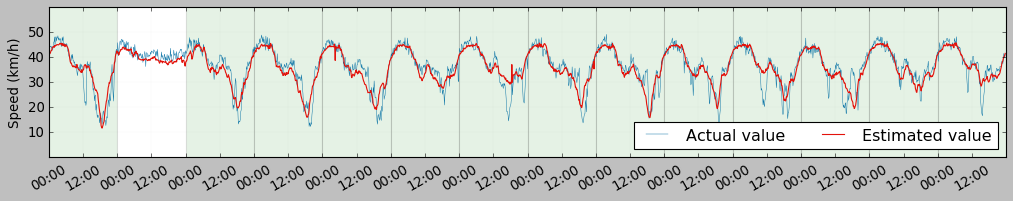

In [21]:
## Visualize the results of missing data imputation
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('classic')
fig = plt.figure(figsize=(13, 2.5))
ax = fig.add_axes([0.05, 0.22, 0.92, 0.75])

plt.plot(dense_mat[0, 0 : 14 * 144 - 1], color = "#006ea3", 
         linewidth = 0.4, label = "Actual value")
plt.plot(mat_hat[0, 0 : 14 * 144 - 1], color = "#e3120b", 
         linewidth = 1.0, label = "Estimated value")

ax.set_xlim([0, 14 * 144 - 1])
ax.set_ylim([0, 60])
ax.grid(color = 'gray', linestyle = '-', linewidth = 0.1, alpha = 0.2)

for i in range(14):
    if sparse_mat[0, 144 * i] > 0:
        someX, someY = i * 144, 0
        currentAxis = plt.gca()
        ax.add_patch(patches.Rectangle((someX, someY), 144, 60,
                      alpha=0.1, facecolor='green'))

plt.xticks(np.arange(0, 14*144, 72),["00:00", "12:00", "00:00", "12:00",
                    "00:00", "12:00", "00:00", "12:00",
                    "00:00", "12:00", "00:00", "12:00",
                    "00:00", "12:00", "00:00", "12:00",
                    "00:00", "12:00", "00:00", "12:00",
                    "00:00", "12:00", "00:00", "12:00",
                    "00:00", "12:00", "00:00", "12:00"], rotation=30)
plt.yticks(np.arange(10,60,10),[10,20,30,40,50,60])
ax.set_ylabel("Speed (km/h)")
plt.legend(ncol=3, loc=4)
plt.show()